In [1]:
# import library
# ========= choice of library ====
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [2]:
# Get the certain STL 10 Data
from skimage import util 
data_location = "../../Dataset/STL10/img/2/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))

image_resize_px = 64
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index],mode='L'),(image_resize_px,image_resize_px))
train_batch_brid = train_batch.copy()    
    
data_location = "../../Dataset/STL10/img/4/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index],mode='L'),(image_resize_px,image_resize_px))
            
train_batch = np.vstack((train_batch_brid,train_batch))            
# print out the data shape and the max and min value
train_batch = np.expand_dims(train_batch,3)
print('Train batch, min, max : ',train_batch.shape,train_batch.min(),train_batch.max())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Train batch, min, max :  (500, 64, 64, 1) 0.0 1.0


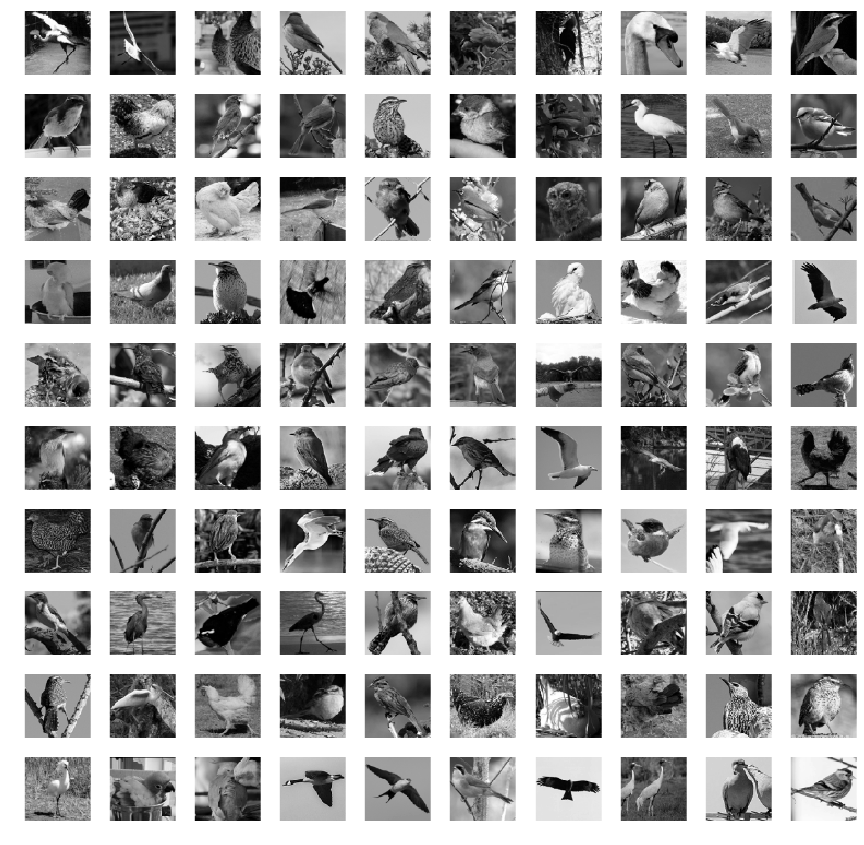

In [3]:
# view random 100 images
idx = np.random.permutation(len(train_batch))
train_batch = train_batch[idx]
fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
plt.show()

In [148]:
# layers
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float64)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float64) * x) + 1.0)
def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)
def tf_tanh(x): return tf.tanh(x)
def d_tf_tanh(x): return 1.0 - tf_tanh(x) ** 2
def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

# ---- FAST ICA Special function ----
def tf_cube(x): return x ** 3
def d_tf_cube(x): return 2* x ** 2
def tf_exp(x): return x * tf.exp(-(x**2)/2.0)
def d_tf_exp(x): return (1-x**2) * tf.exp(-(x**2)/2.0)

class CNN():

    def __init__(self,k,inc,out,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='SAME',l2_reg = False):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        ) / batch_size

        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        )

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))

        return grad_pass,update_w
    
class tf_pca_layer():
    
    def __init__(self,n_components):
        self.n_components = tf.Variable(n_components)
    
    def feedforward(self,input):
        self.input = input
        self.cov = tf.matmul(self.input,tf.transpose(self.input)) / (input.shape[0].value-1)
        self.eigval,self.pc = tf.linalg.eigh(self.cov)
        self.pc_projection = self.pc[:,-self.n_components:]
        self.layer = tf.matmul(tf.transpose(self.pc_projection),input)
        return self.layer
    
    def backprop(self,grad):
        mat_shape = self.input.shape[0].value
        d_pc_project = tf.transpose(tf.matmul(grad,tf.transpose(self.input)))
        diff = mat_shape - self.n_components
        added_mat = tf.zeros([mat_shape,diff],dtype=tf.float64)
        d_pc = tf.concat([d_pc_project,added_mat],1)
        E = tf.matmul(tf.ones([mat_shape,1],dtype=tf.float64),tf.transpose(self.eigval)[tf.newaxis,:]) - \
            tf.matmul(self.eigval[:,tf.newaxis],tf.ones([1,mat_shape],dtype=tf.float64))
        F = 1.0/(E + tf.eye(mat_shape,dtype=tf.float64)) - tf.eye(mat_shape,dtype=tf.float64)
        d_cov = tf.matmul(tf.linalg.inv(tf.transpose(self.pc)),
                tf.matmul(F * (tf.matmul(tf.transpose(self.pc),d_pc)),tf.transpose(self.pc)))
        d_x = tf.matmul(self.pc_projection,grad) + \
              (tf.matmul(d_cov,self.input) + tf.matmul(tf.transpose(d_cov),self.input))/(mat_shape-1)
        return d_x
    
class FastICA_Layer():
    """Performs ICA via FastICA method

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    outc : type
        Description of parameter `outc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    sym_decorrelation : type
        Description of attribute `sym_decorrelation`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    self,matrix : type
        Description of attribute `self,matrix`.
    act
    d_act

    """

    def __init__(self,inc,outc,act,d_act):
        self.w = tf.Variable(self.sym_decorrelation(tf.random_normal(shape=[inc,outc],stddev=0.05,dtype=tf.float64,seed=2)))
        self.m = tf.Variable(tf.zeros_like(self.w)) ; self.v = tf.Variable(tf.zeros_like(self.w))
        self.act = act; self.d_act = d_act

    def sym_decorrelation(self,matrix):
        s, u = tf.linalg.eigh(tf.matmul(matrix,tf.transpose(matrix)))
        decor_matrx = tf.matmul(u * (1.0/tf.sqrt(s)),tf.transpose(u))
        return tf.matmul(decor_matrx,matrix)

    def getw(self): return self.w

    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer

    def backprop_ica(self):
        self.layerA  = self.act(tf.matmul(self.w,self.input))
        self.layerDA = tf.reduce_mean(self.d_act(tf.matmul(self.w,self.input)),-1)
        grad_pass = tf.matmul(tf.transpose(self.w),self.layer)
        
        grad_w = tf.matmul(self.layerA,tf.transpose(self.input)) / self.input.shape[1].value - self.layerDA[:,tf.newaxis] * self.w
        grad = self.sym_decorrelation(grad_w)
        
        update_w = []
        
        # ==== Correct Method of Weight Update ====
#         update_w.append(tf.assign(self.w,grad))
        
        # ==== Wrong (gradient ascent) Method of Weight Update ====
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        
        return grad_pass,update_w
    
class tf_mean_layer():
    
    def __init__(self):
        pass
    
    def feedforward(self,input):
        self.mean = tf.reduce_mean(input,1)
        return input-self.mean[:,tf.newaxis]
    
    def backprop(self,grad):
        return grad * (1 + grad.shape[0].value)

In [149]:
# define hyper, class and graph
num_epcoch = 300 ; learning_rate = 0.0008; print_size = 100
batch_size = 500
beta1,beta2,adam_e = 0.9,0.999,1e-8

l1 = CNN(3,1,1,act=tf_elu,d_act=d_tf_elu)
l2 = CNN(3,1,1,act=tf_elu,d_act=d_tf_elu)
l3 = CNN(3,1,1,act=tf_sigmoid,d_act=d_tf_sigmoid)

pca_l_1 = tf_pca_layer(10)
pca_l_2 = tf_pca_layer(10)
pca_l_3 = tf_pca_layer(10)
pca_l_4 = tf_pca_layer(10)
ica_l_1 = FastICA_Layer(10,10,act=tf_exp,d_act=d_tf_exp)
ica_l_2 = FastICA_Layer(10,10,act=tf_tanh,d_act=d_tf_tanh)
ica_l_3 = FastICA_Layer(10,10,act=tf_cube,d_act=d_tf_cube)
ica_l_4 = FastICA_Layer(10,10,act=tf_sigmoid,d_act=d_tf_sigmoid)


x = tf.placeholder(shape=[batch_size,64,64,1],dtype=tf.float64)
layer1 = l1.feedforward(x,padding='VALID')
layer2 = l2.feedforward(layer1,padding='VALID') 
layer3 = l3.feedforward(layer2,padding='VALID') 
layer_flat = tf.reshape(layer3,[batch_size,-1])

pca_layer_1 = pca_l_1.feedforward(layer_flat[:125,:])
pca_layer_2 = pca_l_2.feedforward(layer_flat[125:250,:])
pca_layer_3 = pca_l_3.feedforward(layer_flat[250:375,:])
pca_layer_4 = pca_l_4.feedforward(layer_flat[375:,:])

ica_layer_1_1 = ica_l_1.feedforward(pca_layer_1)
ica_layer_2_1 = ica_l_2.feedforward(pca_layer_2)
ica_layer_3_1 = ica_l_3.feedforward(pca_layer_3)
ica_layer_4_1 = ica_l_4.feedforward(pca_layer_4)

ica_layer_feed = []
ica_layer_grad_1 = []
ica_layer_grad_2 = []
ica_layer_grad_3 = []
ica_layer_grad_4 = []
ica_layer_grad_up = []

for _ in range(10):
    ica_layer_1 = ica_l_1.feedforward(pca_layer_1)
    ica_layer_2 = ica_l_2.feedforward(pca_layer_2)
    ica_layer_3 = ica_l_3.feedforward(pca_layer_3)
    ica_layer_4 = ica_l_4.feedforward(pca_layer_4)
    all_ica_section_2 = ica_layer_1 + ica_layer_2 + ica_layer_3 +ica_layer_4
    ica_layer_feed.append(all_ica_section_2)
    grad_ica_1,grad_ica_up_1 = ica_l_1.backprop_ica()
    grad_ica_2,grad_ica_up_2 = ica_l_2.backprop_ica()
    grad_ica_3,grad_ica_up_3 = ica_l_3.backprop_ica()
    grad_ica_4,grad_ica_up_4 = ica_l_4.backprop_ica()
    ica_layer_grad_1.append(grad_ica_1)
    ica_layer_grad_2.append(grad_ica_2)
    ica_layer_grad_3.append(grad_ica_3)
    ica_layer_grad_4.append(grad_ica_4)
    ica_layer_grad_up.append(grad_ica_up_1+grad_ica_up_2+grad_ica_up_3+grad_ica_up_4)
    
ica_layer_all = tf.reduce_mean(tf.convert_to_tensor(ica_layer_feed),0)
grad_ica_mean_1 = tf.reduce_mean(tf.convert_to_tensor(ica_layer_grad_1),0)
grad_ica_mean_2 = tf.reduce_mean(tf.convert_to_tensor(ica_layer_grad_2),0)
grad_ica_mean_3 = tf.reduce_mean(tf.convert_to_tensor(ica_layer_grad_3),0)
grad_ica_mean_4 = tf.reduce_mean(tf.convert_to_tensor(ica_layer_grad_4),0)

grad_pca_1 = pca_l_1.backprop(grad_ica_mean_1)
grad_pca_2 = pca_l_2.backprop(grad_ica_mean_2)
grad_pca_3 = pca_l_3.backprop(grad_ica_mean_3)
grad_pca_4 = pca_l_4.backprop(grad_ica_mean_4)

grad_pca_reshape = tf.reshape(tf.concat([grad_pca_1,grad_pca_2,grad_pca_3,grad_pca_4],0),[batch_size,58,58,1])
grad_3,grad_3_up = l3.backprop(grad_pca_reshape,padding='VALID') 
grad_2,grad_2_up = l2.backprop(grad_3,padding='VALID') 
grad_1,grad_1_up = l1.backprop(grad_2,padding='VALID') 
grad_up = ica_layer_grad_up + grad_3_up+ grad_2_up + grad_1_up

In [ ]:
# show some examples and start the training
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for iter in range(num_epcoch):
    train_batch = shuffle(train_batch)
    for current_batch_index in range(0,len(train_batch),batch_size):
        current_data = train_batch[current_batch_index:current_batch_index+batch_size,:,:,:]
        sess_results = sess.run([all_ica_section_2,grad_up],feed_dict={x:current_data})
    print('iter: ',iter,' mean: ',sess_results[0].mean())

iter:  0  mean:  0.34708413400059307
iter:  1  mean:  0.34261422830182414
iter:  2  mean:  0.336577913415341
iter:  3  mean:  0.3295353843813878
iter:  4  mean:  0.32177968839616555
iter:  5  mean:  0.3134152283950839
iter:  6  mean:  0.3047889469741094
iter:  7  mean:  0.2958093789612833
iter:  8  mean:  0.28663605044314133
iter:  9  mean:  0.2771840123522059
iter:  10  mean:  0.26793455952692846
iter:  11  mean:  0.2584831830754735
iter:  12  mean:  0.2490189197670897
iter:  13  mean:  0.23954608474495748
iter:  14  mean:  0.23006868213002876
iter:  15  mean:  0.22064153551446364
iter:  16  mean:  0.21126388489850287
iter:  17  mean:  0.20190178726220817
iter:  18  mean:  0.19260796158661783
iter:  19  mean:  0.18320186649640485
iter:  20  mean:  0.1741806105465308
iter:  21  mean:  0.16505883624887313
iter:  22  mean:  0.1561538519280407
iter:  23  mean:  0.1473533713288837
iter:  24  mean:  0.13843764498271446
iter:  25  mean:  0.12970588376688208
iter:  26  mean:  0.12089749509765

iter:  210  mean:  -0.260942705550823
iter:  211  mean:  -0.25588841464604517
iter:  212  mean:  -0.2442024606996191
iter:  213  mean:  -0.29542329763070596
iter:  214  mean:  -0.24555982709757207
iter:  215  mean:  -0.25116816396904373
iter:  216  mean:  -0.22961030554697248
iter:  217  mean:  -0.27107630991921455
iter:  218  mean:  -0.23856491396986093
iter:  219  mean:  0.30860557263056787
iter:  220  mean:  -0.2535239660748359
iter:  221  mean:  -0.26377891374802614
iter:  222  mean:  -0.2833739060844179
iter:  223  mean:  0.30442999884029853
iter:  224  mean:  -0.244981127507468
iter:  225  mean:  -0.22980473762040243
iter:  226  mean:  -0.258909914213206
iter:  227  mean:  -0.24817988930670606
iter:  228  mean:  -0.2568458532147753
iter:  229  mean:  -0.25607542693096214
iter:  230  mean:  -0.24065657184053962
iter:  231  mean:  -0.24156969123958147
iter:  232  mean:  -0.2496972990990673
iter:  233  mean:  -0.23578939912479946
iter:  234  mean:  -0.23978460317587452
iter:  235  m

In [ ]:
# get all of the results for the layers (norm)
sess_results = sess.run([layer1,layer2,layer3],feed_dict={x:train_batch[:batch_size]})
all_data_c = []
for temp_data in sess_results:
    print(temp_data.shape)
    reshape_data = temp_data.reshape(500,-1,1)
    reshape_data[:,:,0] = (reshape_data[:,:,0]-reshape_data[:,:,0].min(1)[:,np.newaxis])/ \
                          (reshape_data[:,:,0].max(1)-reshape_data[:,:,0].min(1) )[:,np.newaxis]
    
#     reshape_data[:,:,1] = (reshape_data[:,:,1]-reshape_data[:,:,1].min(1)[:,np.newaxis])/ \
#                           (reshape_data[:,:,1].max(1)-reshape_data[:,:,1].min(1) )[:,np.newaxis]
    
#     reshape_data[:,:,2] = (reshape_data[:,:,2]-reshape_data[:,:,2].min(1)[:,np.newaxis])/ \
#                           (reshape_data[:,:,2].max(1)-reshape_data[:,:,2].min(1) )[:,np.newaxis]
    all_data_c.append(reshape_data)

In [ ]:
# get all of the results for the ica (norm)
sess_results = sess.run([ pca_layer_1,pca_layer_2,pca_layer_3,pca_layer_4,
                          ica_layer_1_1,ica_layer_2_1,ica_layer_3_1,ica_layer_4_1],feed_dict={x:train_batch[:batch_size]})
for temp in sess_results:
    print(temp.shape)
    
all_data = []
for ssss in sess_results:
    ssss_reshape = ssss.reshape(ssss.shape[0],58,58,1)
    ssss_reshape_2 = ssss_reshape.reshape(ssss.shape[0],-1,1)
    ssss_reshape_2[:,:,0] = (ssss_reshape_2[:,:,0]-ssss_reshape_2[:,:,0].min(1)[:,np.newaxis])/ \
                          (ssss_reshape_2[:,:,0].max(1)-ssss_reshape_2[:,:,0].min(1) )[:,np.newaxis]
    
#     ssss_reshape_2[:,:,1] = (ssss_reshape_2[:,:,1]-ssss_reshape_2[:,:,1].min(1)[:,np.newaxis])/ \
#                           (ssss_reshape_2[:,:,1].max(1)-ssss_reshape_2[:,:,1].min(1) )[:,np.newaxis]
    
#     ssss_reshape_2[:,:,2] = (ssss_reshape_2[:,:,2]-ssss_reshape_2[:,:,2].min(1)[:,np.newaxis])/ \
#                           (ssss_reshape_2[:,:,2].max(1)-ssss_reshape_2[:,:,2].min(1) )[:,np.newaxis]
    
    print(ssss_reshape_2.min(1).sum(),ssss_reshape_2.max(1).sum())
    all_data.append(ssss_reshape_2)

In [ ]:
# show the results
fig=plt.figure(figsize=(30, 30))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[:batch_size][i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

for temp in all_data_c:
    fig=plt.figure(figsize=(30, 30))
    columns = 10 ; rows = 10
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        try:
            num = int(np.sqrt(temp[i-1].shape[0]))
            plt.imshow(np.squeeze(temp[i-1]).reshape(num,num),cmap='gray')
        except:
            break
        plt.axis('off')
        plt.title(str(i))
    plt.show()
    print('-------------------------------------')

count = 0
for temp in all_data:
    fig=plt.figure(figsize=(30, 30))
    columns = 10 ; rows = 1
    for i in range(1, columns*rows +1):
        try:
            fig.add_subplot(rows, columns, i)
            num = int(np.sqrt(temp[i-1].shape[0]))
            plt.imshow(np.squeeze(temp[i-1]).reshape(num,num),cmap='gray')
        except:
            break
        plt.axis('off')
        plt.title(str(i))
    count = count + 1
    if count==5:
        print('-------------------------------------')
    plt.show()

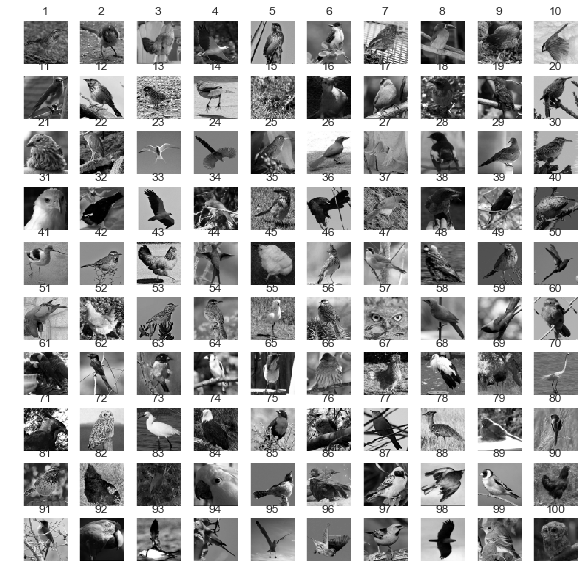

-------------------------------------


TypeError: Invalid dimensions for image data

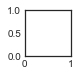

In [14]:
# past view

fig=plt.figure(figsize=(10, 10))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(current_data[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

fig=plt.figure(figsize=(10, 10))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(data1[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

fig=plt.figure(figsize=(10, 10))
columns = 10 ; rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(data2[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

fig=plt.figure(figsize=(10, 10))
columns = 10 ; rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(np.squeeze(data_pca[i-1]),cmap='gray')
    except:
        pass
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

fig=plt.figure(figsize=(10, 10))
columns = 10 ; rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(np.squeeze(data_ica[i-1]),cmap='gray')
    except:
        pass
    plt.axis('off')
    plt.title(str(i))
plt.show()
print('-------------------------------------')

(500, 4096)


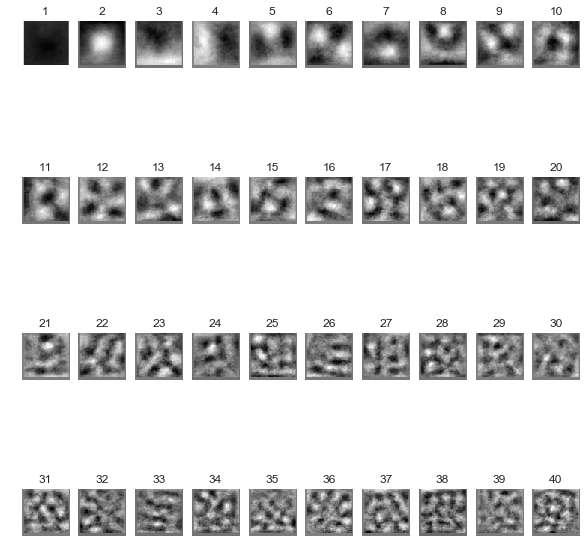

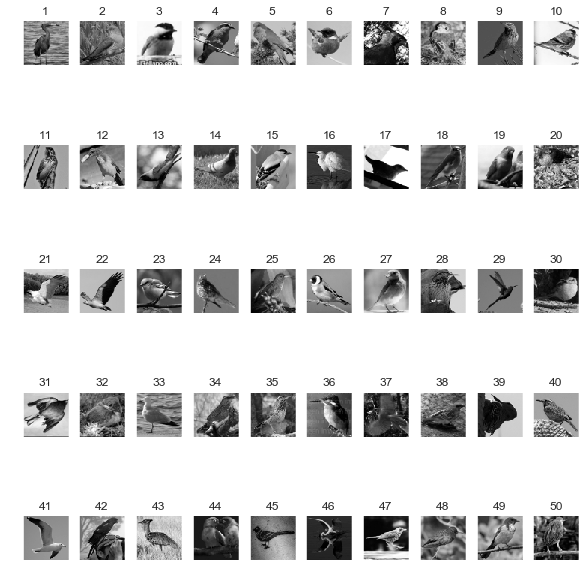

In [208]:
# sk pca
sk_test_data = train_batch.reshape(500,-1)
print(sk_test_data.shape)
from sklearn.decomposition import PCA
sk_pca = PCA(n_components=40)
sk_pca_data = sk_pca.fit_transform(sk_test_data.T).T
sk_pca_data = sk_pca_data.reshape(40,64,64)
fig=plt.figure(figsize=(10, 11))
columns = 10 ; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(sk_pca_data[i-1],cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()

fig=plt.figure(figsize=(10, 11))
columns = 10 ; rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()

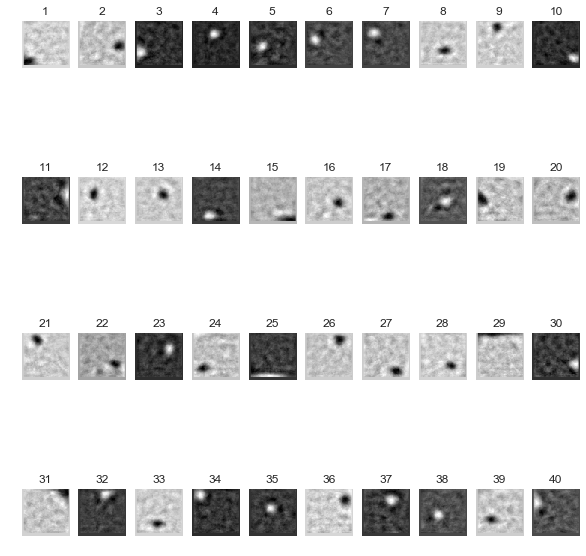

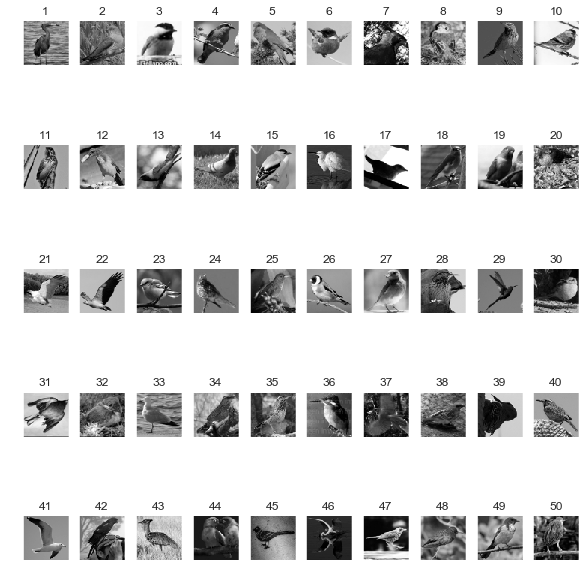

In [209]:
# sk ica
from sklearn.decomposition import FastICA
sk_ica = FastICA(n_components=40)
sk_ica_data = sk_ica.fit_transform(sk_test_data.T).T
sk_ica_data = sk_ica_data.reshape(40,64,64)
fig=plt.figure(figsize=(10, 11))
columns = 10 ; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(sk_ica_data[i-1],cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()

fig=plt.figure(figsize=(10, 11))
columns = 10 ; rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()

In [122]:
! git all-go


[master ec7649aa] s
 4 files changed, 7550 insertions(+), 3317 deletions(-)
 create mode 100644 Understanding_Concepts/review_ICA_PCA/.ipynb_checkpoints/y from basic to bird-Copy1-checkpoint.ipynb
 rewrite Understanding_Concepts/review_ICA_PCA/.ipynb_checkpoints/y from basic to bird-checkpoint.ipynb (61%)
 create mode 100644 Understanding_Concepts/review_ICA_PCA/y from basic to bird-Copy1.ipynb
 rewrite Understanding_Concepts/review_ICA_PCA/y from basic to bird.ipynb (64%)


The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   5a248b82..ec7649aa  master -> master
